# AIRDOS G data processing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob

In [2]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [510]:
#fto = './data/malaga/16/DATALOG.TXT' #  File to Open
#fto = './data/malaga/21/DATALOG.TXT' #  File to Open
#fto = './data/malaga/98/DATALOG.TXT' #  File to Open
fto = './data/malaga/F0/DATALOG.TXT' #  File to Open

print (fto)

l=[]
#l.extend(range(0,261))
l.extend(range(0,258))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS'][3]
print (sn[0])
#df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)

# Convert strings to numbers
#df = df.apply(pd.to_numeric, errors='ignore')

#df.iloc[:,0:13]

#df

./data/malaga/F0/DATALOG.TXT
1290c00806a20090f457a000a00000f0


## Derive measurement runs in to separate files

In [511]:
run = 0

runs = []
LatDD = np.nan
LatD = np.nan
LatM = np.nan
LonDD = np.nan
LonD = np.nan
LonM = np.nan

for i,r in df.iterrows():
    if (r[0] == '$AIRDOS'):
        run = run + 1
        date = np.nan #pd.to_datetime('210317000000.00', format='%d%m%y%H%M%S.%f')
        time = 0
        timedelta = 0
        altitude = np.nan
        Lat = np.nan
        Lon = np.nan
        speed = np.nan
        flag = 0
        flagrun = 0
        print (run, end='')
        
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        LatHem = r.astype(str)[4]
        LonHem = r.astype(str)[6]
        if (LatHem=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (LonHem=='W'):
            LonS = -1
        else:
            LonS = 1
        Lat = float(r[3])
        LatD = np.trunc(Lat/100)
        LatM = ((Lat/100) - LatD) * 100
        LatDD = LatD + LatM/60.0
        LatDD = LatDD * LatS  
        Lon = float(r[5])
        LonD = np.trunc(Lon/100)
        LonM = ((Lon/100) - LonD) * 100
        LonDD = LonD + LonM/60.0
        LonDD = LonDD * LonS         
        flag = 1
       
    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$CANDY'):
        time = pd.to_numeric(r[2])  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timedelta, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        df.at[i,'latD'] = LatD
        df.at[i,'lonD'] = LonD
        df.at[i,'latM'] = LatM
        df.at[i,'lonM'] = LonM
        df.at[i,'latHem'] = LatHem
        df.at[i,'lonHem'] = LonHem
        
  
FROM = pd.to_datetime('2019-11-27 00:00:00')
TO = pd.to_datetime('2019-11-29 01:10:00')


dfo = df.copy()
dfo = dfo.loc[(dfo['date']>FROM)&(dfo['date']<TO)]

#01/2002, FL-27
#DEG MIN N/S DEG MIN E/W FEET TIME(MIN)
dfdeg = df[['latD','latM','latHem','lonD','lonM','lonHem','altitude','run','date']].copy()
dfdeg['altitude'] *= 3.28084
dfdeg['minute'] = 0
dfo['minute'] = 0
dfdeg = dfdeg.loc[(dfdeg['date']>FROM)&(dfdeg['date']<TO)]
#dfdeg.reset_index(inplace=True)

dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfdeg.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)

'''
TODO !!!!!!!!!!!!!!!!!!!!
# calculate empty dates
for x in runs:
    print x
    dfo.loc[(dfo['date'].isnull())&(dfo['run'] == x[0]),'TBD'] = x[0]
    dfo.loc[dfo['TBD'] == x[0],'time'] = pd.to_datetime(x[1] + (pd.to_timedelta(pd.to_numeric(dfo.loc[dfo['TBD'] == x[0],2]), unit='s')) - pd.to_timedelta(x[2], unit='s'))
    dfo.loc[(dfo['time'].isnull())&(dfo['run'] == x[0]),'time'] = dfo.loc[(dfo['time'].isnull())&(dfo['run'] == x[0]),'date']

dfo.drop(['TBD','date'], axis = 1, inplace = True, errors = 'ignore')
'''
print ()

for f in glob.iglob("./output/*.csv"): # delete all output files 
    print ('Deleting', f)
    os.remove(f)


dfo.set_index('date', inplace = True)

#01/2002, FL-27
#DEG MIN N/S DEG MIN E/W FEET TIME(MIN)

for x in runs: 
    filename = './output/' + str(x[1] + pd.to_timedelta(-x[2], unit='s')) + '_' + str(sn[0])

    # Disimetric values
    dfo.loc[dfo['run'] == x[0],'minute'] = (pd.to_timedelta(dfo.loc[dfo['run'] == x[0]].index-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)
    dfo.loc[dfo['run'] == x[0]].to_csv(filename + '.csv')

    # Telemetry for CARI 7
    with open(filename + '.DEG', 'w') as f:
        f.write('01/2002, FL-27\r\n')
        f.write('DEG MIN N/S DEG MIN E/W FEET TIME(MIN)\r\n')
    with open('ble.DEG', 'w') as f:
        f.write('11/2019, FL-27\r\n')
        f.write('DEG MIN N/S DEG MIN E/W FEET TIME(MIN)\r\n')
    dfdeg.loc[dfdeg['run'] == x[0],'minute'] = (pd.to_timedelta(dfdeg['date']-(x[1] + pd.to_timedelta(-x[2], unit='s')))).astype('timedelta64[m]').fillna(0).astype(int)
    dfdeg.loc[dfdeg['run'] == x[0],['latD','latM', 'latHem', 'lonD', 'lonM', 'lonHem', 'altitude', 'minute']].dropna().drop_duplicates(subset='minute', keep='first').to_csv('ble.DEG', mode='a', index=False, header=False, line_terminator='\r\n')

print('End')

12
Deleting ./output/2019-11-28 16:55:09_1290c00806a200912457a000a0000021.csv
End


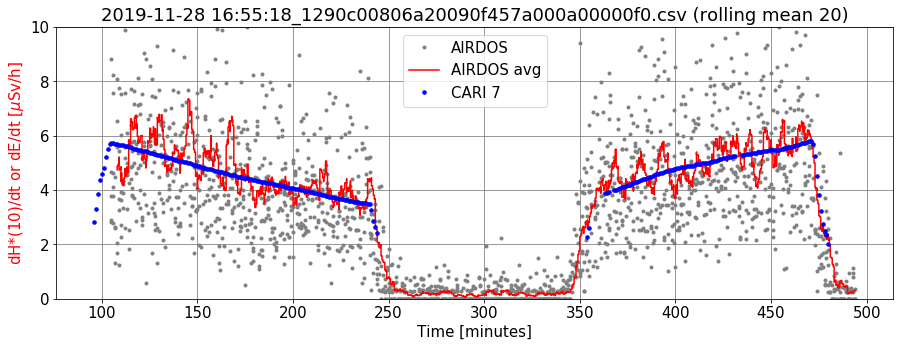

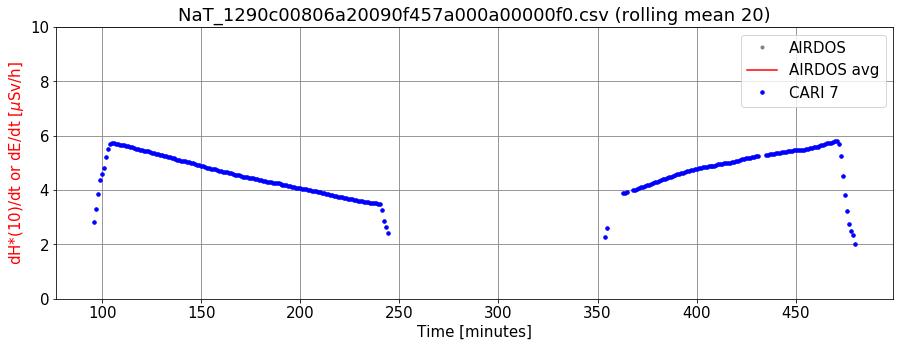

In [512]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8
LAST_CHANNEL=254
WINDOW = 20

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    plt.figure(figsize=(15,5))
    plt.tight_layout()
    xx = pd.read_csv(f)
    xx['date'] = pd.to_datetime(xx['date'])
    #xx.set_index('date', inplace = True)
    #xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']

    s = f.split('/')
    plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        
    # Deposited energy
    e = pd.DataFrame()
    e['Ch']=range(0,256)
    e['ener'] = e.index * 0.038 + 0.105
    xx['ener'] = (np.asarray(xx.iloc[:,8:256]) * np.asarray(e.loc[3:250,'ener'])).sum(axis=1)    
    

    # size of the chip (20 mm · 10 mm), 
    # the thickness of the depletion layer (0.3 mm), 
    # and the density of silicon (2.33 g cm^3)
    # 0.1398e-3 kg
    xx['dsi'] = ((1e6 * (1.602e-19 * xx['ener'] * 1e6)/0.1398e-3)/10.4) * 3600 * 2.71 # in uGy/h

    xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

    xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()
    xx['dsimean'] = xx['dsi'].rolling(WINDOW).mean()

    #plt.plot(xx['minute'], xx['flux'], c='gray', linestyle='', marker='.')
    plt.plot(xx['minute'], xx['dsi'], c='gray', linestyle='', marker='.', label='AIRDOS')
    plt.plot(xx['minute'],xx['dsimean'],c='red', drawstyle='steps-mid', label='AIRDOS avg')
    #plt.plot(xx.iloc[:,'minute'],xx['fluxmean']c='red')
    #plt.plot(xx.loc[:,'minute'],xx.iloc[:,NOISE_LEVEL],c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

    # CARI 7
    f = './data/ble.DAT' #  File to Open
    df = pd.read_csv(f, engine='python', header=None, delim_whitespace=True, skiprows=2, skipfooter=3 )
    plt.plot(df.loc[(df[3]>95)&(df[4]>2),3],df.loc[(df[3]>95)&(df[4]>2),4], c='blue', markersize=7, marker='.', linestyle='none', label='CARI 7')
    
    plt.ylim([0,10])
    #plt.yscale('log')

    plt.xlabel('Time [minutes]')
    plt.ylabel(r'dH*(10)/dt or dE/dt [$\mu$Sv/h]', color='red')
    plt.legend(loc=2)
    
    '''
    ax = plt.twinx()

    plt.ylim([0,14000])
    plt.plot(xx['minute'], xx['altitude'], c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
    plt.ylabel('altitude a.s.l. [m]', color='blue')
    '''
    plt.grid(b=True, which='major', color='grey', linestyle='-')
    plt.grid(b=True, which='minor', color='grey', linestyle='-')
    plt.legend()


## Plot Flux

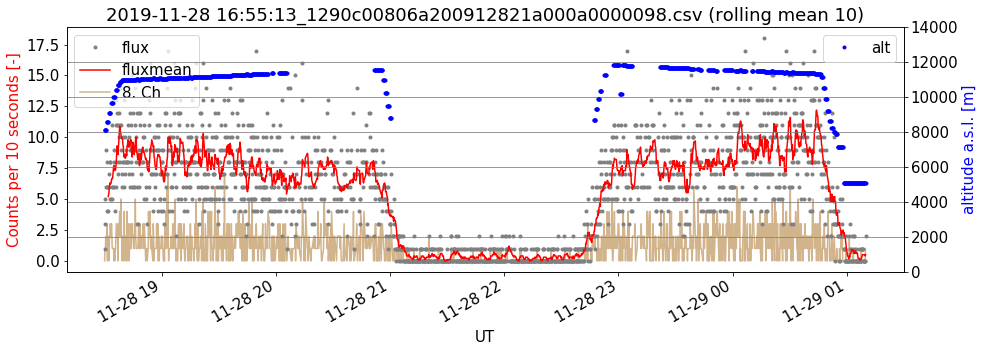

In [303]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 8
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        xx = pd.read_csv(f)
        xx['date'] = pd.to_datetime(xx['date'])
        xx.set_index('date', inplace = True)
        #xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']

        
        xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

        xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

        xx['flux'].plot(c='gray', linestyle='', marker='.')
        xx['fluxmean'].plot(c='red')
        xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

        s = f.split('/')
        plt.title(s[len(s)-1] + ' (rolling mean ' + str(WINDOW) + ')')
        #plt.ylim([0,20])
        plt.xlabel('UT')
        plt.ylabel('Counts per 10 seconds [-]', color='red')
        plt.legend(loc=2)

        ax = plt.twinx()
                
        plt.ylim([0,14000])
        xx['altitude'].plot(c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
        plt.ylabel('altitude a.s.l. [m]', color='blue')

        plt.grid(b=True, which='major', color='grey', linestyle='-')
        plt.grid(b=True, which='minor', color='grey', linestyle='-')
        plt.legend()
                
    except:
        pass



# CARI 7

In [285]:
f = './data/ble.DAT' #  File to Open
df = pd.read_csv(f, engine='python', header=None, delim_whitespace=True, skiprows=2, skipfooter=3 )


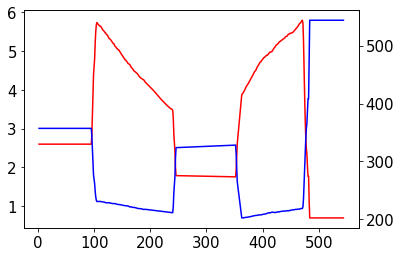

In [286]:
plt.plot(df[3],df[4], c='red')
plt.twinx()
plt.plot(df[3],df[2], c='blue')

## Plot Energy Spectra

0.05168067226890757 -0.16176470588235295


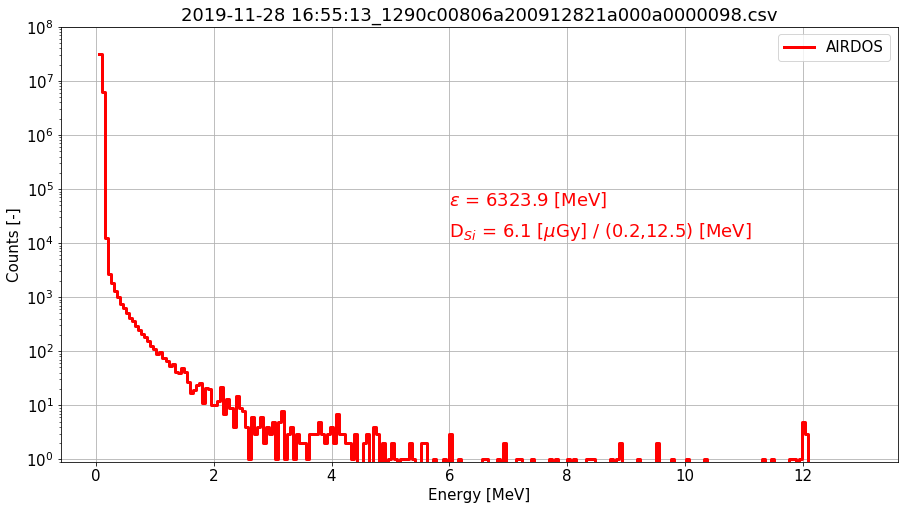

In [313]:
FROM_ENERGY = 0.2
TO_ENERGY = 12.5

l = np.array([[7, 1],[245,1]]) # Calibration
r = np.array([0.2, 12.5])
coef = np.linalg.solve(l,r)
print (coef[0], coef[1])

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:        
        LOW_ENERGY = 4
        
        df = pd.read_csv(f)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace = True)
        
        # Uncomment this if you are interested in a specific time interval
        #xx = df.loc['2019-01-24 05:00:00':'2019-01-24 13:00:00']
        xx = df
        ener1 = xx.iloc[:,LOW_ENERGY:255].sum()
        e = pd.DataFrame()
        e['1'] = ener1
        e['index'] = pd.to_numeric(ener1.index)
        e['x'] = (e['index']) * coef[0] + coef[1]
        e['deposit'] = e['1'] * e['x']
        depener = e.loc[(e['x']>=FROM_ENERGY)&(e['x']<=TO_ENERGY),'deposit'].sum() # MeV
        # size of the chip (21.2 mm · 11.2 mm), 
        # the thickness of the depletion layer (0.3 mm), 
        # and the density of silicon (2.33 g cm^3)
        dose = 1e6*(1.602e-19 * depener*1e6)/0.16597e-3 

        if (depener > 0):
            plt.figure(figsize=(15,8))
            plt.tight_layout()
            s = f.split('/')
            plt.title(s[len(s)-1])
            plt.yscale('log')
            plt.ylim([0.9,1e8])

            plt.plot(e['x'],e['1'], c='r', lw=3, drawstyle='steps-post', label='AIRDOS')

            plt.text(6, 50000, r'$\epsilon$ = ' + str(round(depener,1)) + ' [MeV]', fontsize=18, color='r')
            plt.text(6, 13000, r'D$_S$$_i$ = ' + str(round(dose,2)) + r' [$\mu$Gy] / (' + str(FROM_ENERGY) + ',' + str(TO_ENERGY) + ') [MeV]', fontsize=18, color='r')

            plt.legend()
            plt.xlabel('Energy [MeV]')
            plt.ylabel('Counts [-]')
            plt.grid()
    except:
        pass


In [316]:
e

,1,index,x,deposit
4,31741584.0,4,0.044958,1.427038e+06
5,6213684.0,5,0.096639,6.004821e+05
6,12349.0,6,0.148319,1.831595e+03
7,2679.0,7,0.200000,5.358000e+02
8,1828.0,8,0.251681,4.600723e+02
9,1299.0,9,0.303361,3.940664e+02
10,1011.0,10,0.355042,3.589475e+02
11,734.0,11,0.406723,2.985345e+02
12,638.0,12,0.458403,2.924613e+02
13,518.0,13,0.510084,2.642235e+02


# Plot Map

<Figure size 1080x360 with 0 Axes>

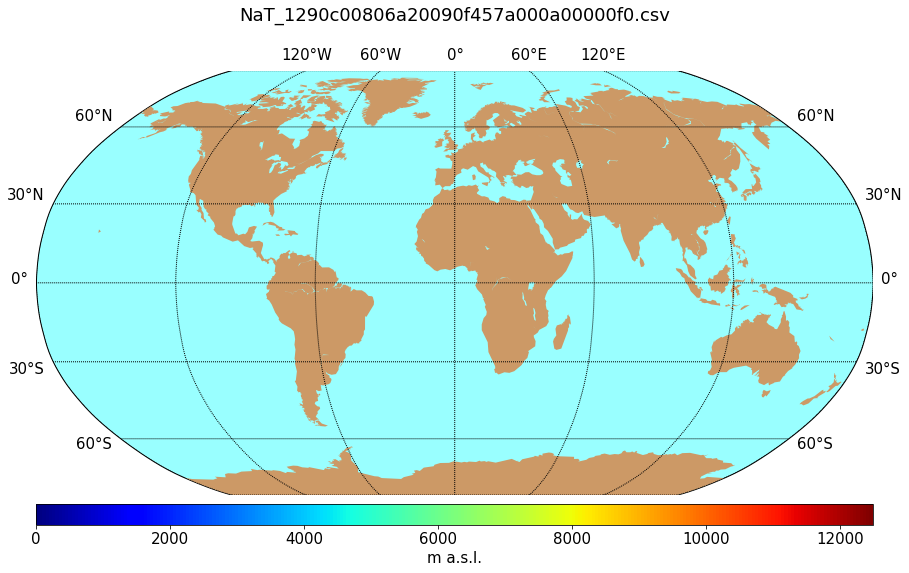

<Figure size 1080x360 with 0 Axes>

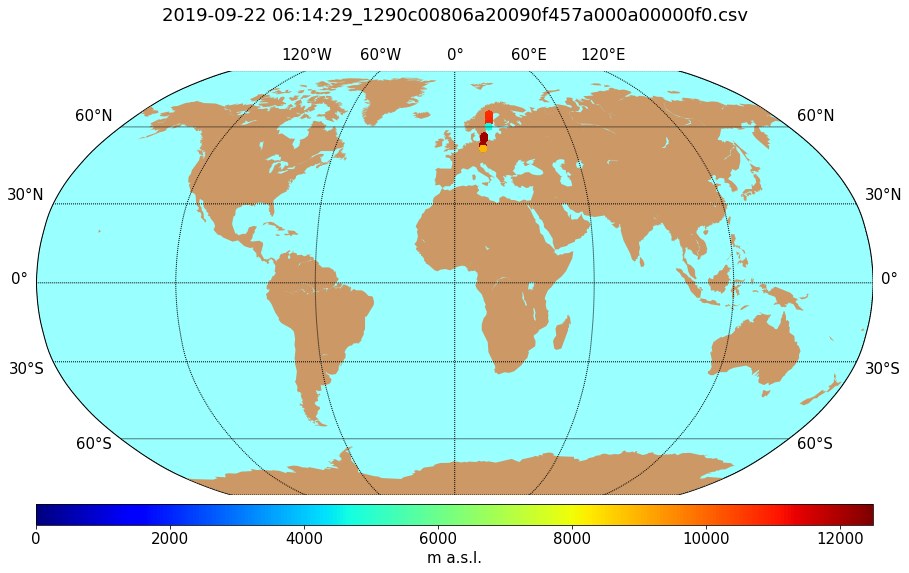

<Figure size 1080x360 with 0 Axes>

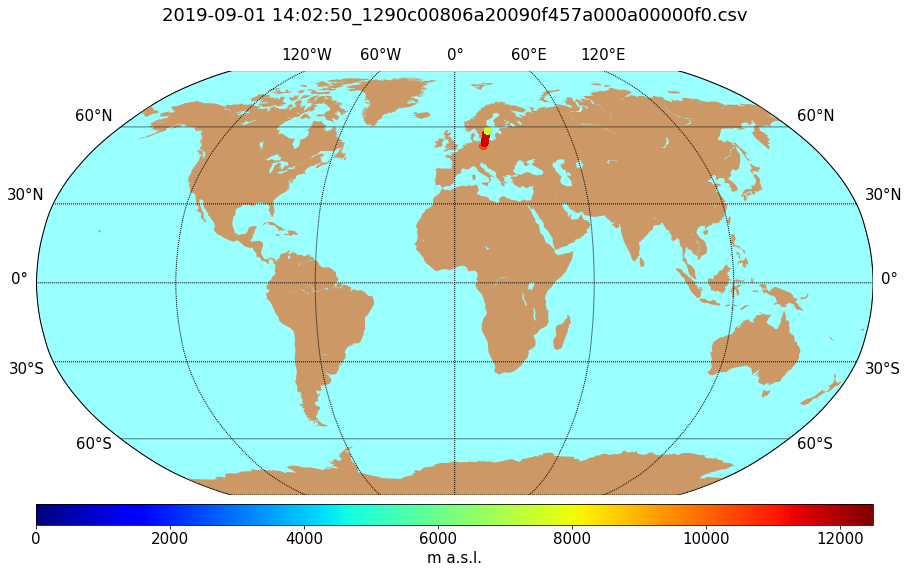

<Figure size 1080x360 with 0 Axes>

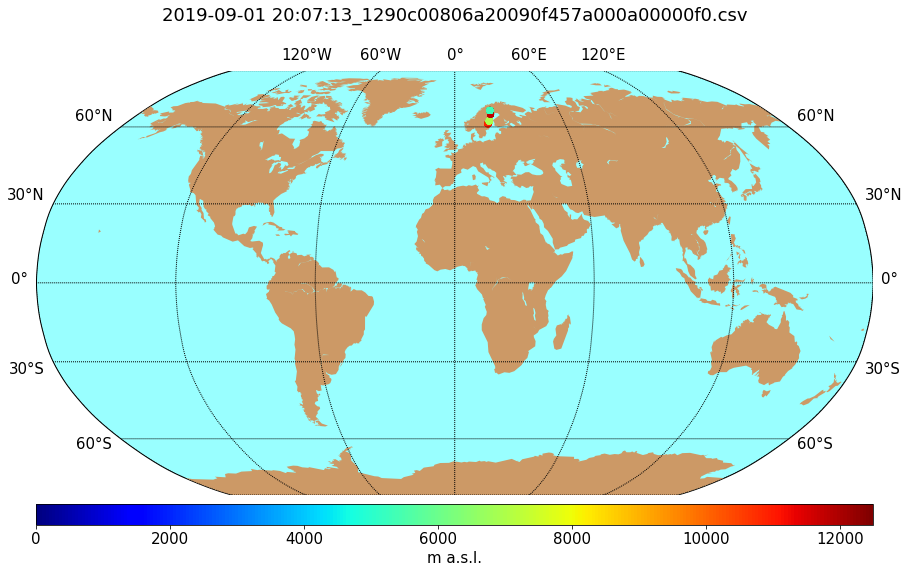

In [15]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os

NOISE_LEVEL= 7
LAST_CHANNEL=254
WINDOW = 10

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    try:
        plt.figure(figsize=(15,5))
        plt.tight_layout()
        df6 = pd.read_csv(f)
        df6.dropna(inplace=True)
        df6['lat'] = pd.to_numeric(df6['lat'])
        df6['lon'] = pd.to_numeric(df6['lon'])
        df6['altitude'] = pd.to_numeric(df6['altitude'])
        
        plt.figure(figsize=(15,15))
        matplotlib.rcParams.update({'font.size': 15})

        # create Basemap instance.
        #m = Basemap(projection='kav7',lon_0=0)
        #m = Basemap(projection='cea',lon_0=0)
        m = Basemap(projection='robin',lon_0=0)
        #m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

        x, y = m(df6.lon.tolist(),df6.lat.tolist())
        m.drawmapboundary(fill_color='#99ffff')
        m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
        # draw parallels and meridians, but don't bother labelling them.
        m.drawparallels(np.arange(-90.,99.,30.),labels=[1,1,0,0])
        m.drawmeridians(np.arange(-180.,180.,60.),labels=[0,0,1,0])
        
        im1 = m.scatter(x,y,c=df6.altitude.tolist(),marker='o', cmap='jet')
        cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
        cb.set_label('m a.s.l.')
        
        s = f.split('/')
        plt.title(s[len(s)-1], pad=50)

        plt.clim(0, 12500)  # limit for color axis
        plt.show()                
    except:
        pass


# REFLECT

In [101]:
fto = './data/A001/DATALOG.TXT' #  File to Open

print (fto)

l=[]
l.extend(range(0,520))
#l.extend(range(0,258))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )
#df = pd.read_table(fto, sep=',', header=None,comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$STROKE'].index, inplace=True)
df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)



./data/A001/DATALOG.TXT


In [114]:
run = 0

runs = []
LatDD = np.nan
LonDD = np.nan

for i,r in df.iterrows():
    if (r[0] == '$GPRMC'):
        date = pd.to_datetime(str(r[9])+str(r[1]), format='%d%m%y%H%M%S.%f',errors='coerce')
        timedelta = time
        speed = r[7]
        if (r.astype(str)[4]=='S'):     # Conferr DDMM.MM to DD.DD
            LatS = -1
        else:
            LatS = 1
        if (r.astype(str)[6]=='W'):
            LonS = -1
        else:
            LonS = 1
        Lat = float(r[3])
        LatDD = (Lat/100)
        LatDD = LatDD + (Lat - 100.0*LatDD)/60.0
        LatDD = LatDD * LatS  
        Lon = float(r[5])
        LonDD = (Lon/100)
        LonDD = LonDD + (Lon - 100.0*LonDD)/60.0
        LonDD = LonDD * LonS         
        flag = 1

    if (r[0] == '$GPGGA'):
        altitude = r[9]

    df.at[i,'date'] = date
    df.at[i,'altitude'] = altitude
    df.at[i,'speed'] = speed

    if (r[0] == '$CANDY'):
        time = pd.to_numeric(r[1])*10  # read seconds from power on
        if (flag == 1):
            timedelta = time
            if (flagrun == 0):
                runs.append([run,date,timedelta])
                flagrun = 1
            flag = 0
        date_line = date + pd.to_timedelta(time - timedelta, unit='s')
        df.at[i,'date'] = date_line
        df.at[i,'run'] = run
        df.at[i,'lat'] = LatDD
        df.at[i,'lon'] = LonDD
        
        
dfo = df.copy()
#dfo.reset_index(inplace=True)
dfo.drop(dfo[dfo[0]=='$GPRMC'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$GPGGA'].index, inplace=True)
dfo.drop(dfo[dfo[0]=='$AIRDOS'].index, inplace=True)



dfo.set_index('date', inplace = True)



In [109]:
dfo.loc['2017-11-29 12:00:00':'2017-11-29 16:00:00']

,0,1,2,3,4,5,6,7,8,9,...,517,518,519,altitude,speed,run,lat,lon,flux,fluxmean
date,,,,,,,,,,,,,,,,,,,,,
2017-11-29 12:02:28,$CANDY,350,0,0,0,0,0,0,0,0,...,7617.0,38652.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,0.0,0.3
2017-11-29 12:02:28,$CANDY,351,0,0,0,0,0,0,0,0,...,7518.0,38628.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,0.0,0.3
2017-11-29 12:02:28,$CANDY,352,0,0,0,0,0,0,0,0,...,7992.0,38684.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,1.0,0.4
2017-11-29 12:02:28,$CANDY,353,0,0,0,0,0,0,0,0,...,8055.0,38728.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,0.0,0.3
2017-11-29 12:02:28,$CANDY,354,0,0,0,0,0,0,0,0,...,8094.0,38686.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,0.0,0.3
2017-11-29 12:02:28,$CANDY,355,0,0,0,0,0,0,0,0,...,7979.0,38693.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,1.0,0.3
2017-11-29 12:02:28,$CANDY,356,0,0,0,0,0,0,0,0,...,7900.0,38715.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,1.0,0.4
2017-11-29 12:02:28,$CANDY,357,0,0,0,0,0,0,0,0,...,7569.0,38719.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,0.0,0.4
2017-11-29 12:02:28,$CANDY,358,0,0,0,0,0,0,0,0,...,7481.0,38757.0,65535.0,432.5,1.440,0.0,50.059411,14.171203,0.0,0.4


/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


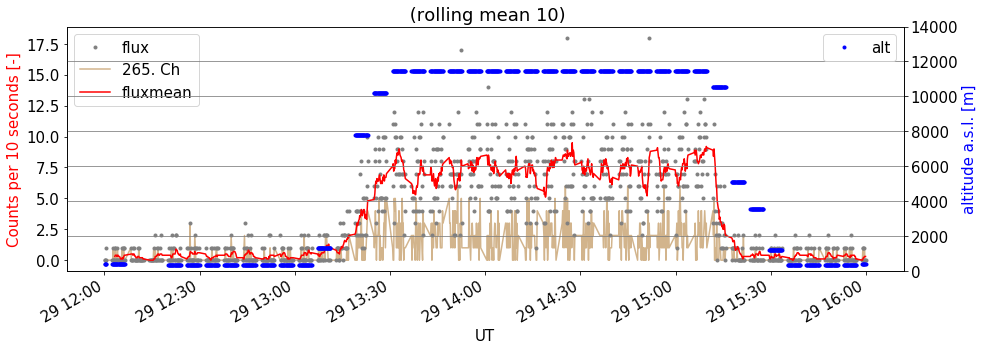

In [115]:
matplotlib.rcParams.update({'font.size': 15})

NOISE_LEVEL= 265
LAST_CHANNEL=400
WINDOW = 10

#xx = dfo
xx = dfo.loc['2017-11-29 12:00:00':'2017-11-29 16:00:00']

plt.figure(figsize=(15,5))
plt.tight_layout()

xx['flux'] = xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx.iloc[:,NOISE_LEVEL].plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)
xx['fluxmean'].plot(c='red')

s = f.split('/')
plt.title(' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,20])
plt.xlabel('UT')
plt.ylabel('Counts per 10 seconds [-]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

plt.ylim([0,14000])
xx['altitude'].plot(c='b', label='alt', marker='.', linewidth='2', linestyle='none', drawstyle='steps-mid')
plt.ylabel('altitude a.s.l. [m]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



## Calculate Flux

<IPython.core.display.Javascript object>


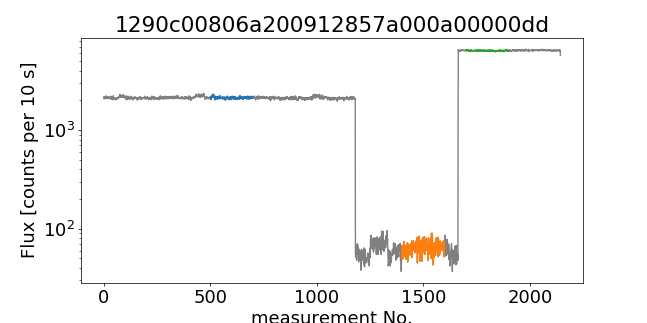

700


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: Deprecat

In [34]:
rc = df.loc[df[0]=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

rc['sum'] = rc[range(6,255)].sum(axis=1)

plt.figure(figsize=(10,5))

rc.ix[0:,'sum'].plot(c='gray')
plt.yscale('log')

e1 = [500,700]
e2 = [1400,1600]
e3 = [1700,1900]
e4 = [1,1]

rc.ix[e1[0]:e1[1],'sum'].plot()
rc.ix[e2[0]:e2[1],'sum'].plot()
rc.ix[e3[0]:e3[1],'sum'].plot()
rc.ix[e4[0]:e4[1],'sum'].plot()

plt.title(sn[0])
plt.xlabel('measurement No.')
plt.ylabel('Flux [counts per 10 s]')
#plt.ylim([0,50])
#plt.xlim([900,1200])

print e1[1]

## Energy spectrum

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: 

<IPython.core.display.Javascript object>


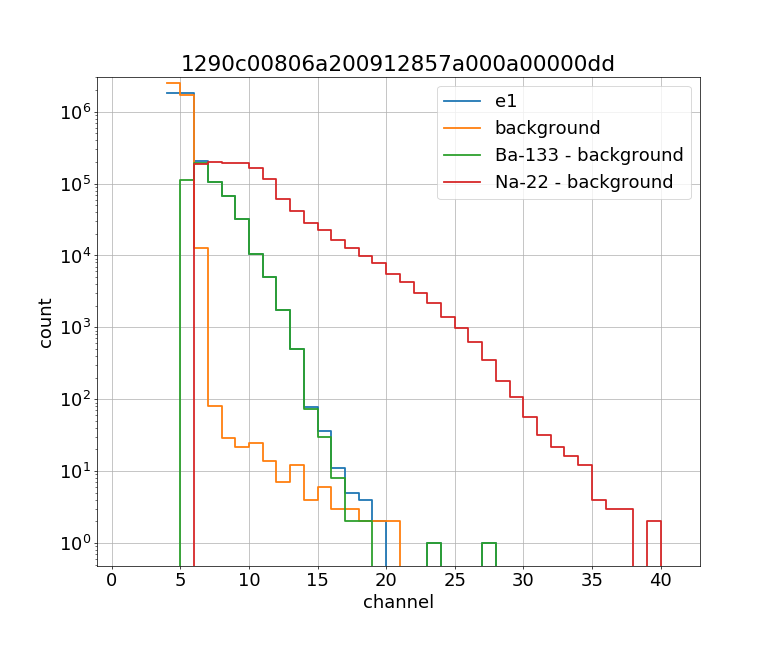

In [42]:
%matplotlib notebook

matplotlib.rcParams.update({'font.size': 20})

LOW_ENERGY = 4

ener1 = rc.ix[e1[0]:e1[1],LOW_ENERGY:255].sum()
ener2 = rc.ix[e2[0]:e2[1],LOW_ENERGY:255].sum()
ener3 = rc.ix[e3[0]:e3[1],LOW_ENERGY:255].sum()
ener4 = rc.ix[e4[0]:e4[1],LOW_ENERGY:255].sum()

plt.figure(figsize=(12,10))
plt.yscale('log')

#plt.plot(ener1, label='e',  drawstyle='steps-post')
plt.plot(ener1, label='e1', lw=2, drawstyle='steps-post')
#plt.plot(ener2, label='e2', lw=2, drawstyle='steps-post')
#plt.plot(ener3, label='e3', lw=2, drawstyle='steps-post')
plt.plot(ener2, label='background', lw=2, drawstyle='steps-post')
plt.plot(ener1-ener2, label='Ba-133 - background', lw=2, drawstyle='steps-post')
plt.plot(ener3-ener2, label='Na-22 - background', lw=2, drawstyle='steps-post')

#plt.ylim([0,10000])
#plt.xlim([0,40])
plt.legend()
plt.title(sn[0])
#plt.title('AIRDOS T4 Alpha Spectrum')
plt.xlabel('channel')
plt.ylabel('count')
#plt.xticks(range(500,1030,10))
#plt.xticks(rotation=90)
plt.grid()

#ener1.to_csv('e1.csv')
#ener2.to_csv('e2.csv')
#ener3.to_csv('e3.csv')

# Spectrum Interactive

In [ ]:
%matplotlib qt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import matplotlib.pyplot as plt

fto = './data/DATALOG.TXT' #  File to Open
#fto = './data/DATALOG_FRA_TRN.TXT' #  File to Open
l=[]
l.extend(range(0,520))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

#
''' DEBUG
df = df.reset_index(drop=True)
df.drop(df[df.index > 100].index, inplace=True)
'''#'''

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
#df.drop(r[r[0]=='$GPRMC'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)
#df.drop(df[df[0]=='$CANDY'].index, inplace=True)


matplotlib.rcParams.update({'font.size': 20})

rc = df.loc[df[0]=='$CANDY']
rc.reset_index(drop=True, inplace=True)

rc = rc.apply(pd.to_numeric, errors='coerce')

#rc.to_csv('ble.txt')

#rc['sum'] = rc[range(260,516)].sum(axis=1)
rc['sum'] = rc[range(260,516)].sum(axis=1)
#rc['sum']

plt.figure(figsize=(20,5))

#rc['sum'].plot()
rc.ix[:,'sum'].plot()

plt.title('AIRDOS')
plt.xlabel('measurement No.')
plt.ylabel('Flux [counts per 11 s]')


points=plt.ginput(2)

plt.figure(figsize=(20,5))
rc.ix[points[0][0]:points[1][0],'sum'].plot()
points=plt.ginput(2)

#ener = rc.ix[points[0][0]:points[1][0],260:516].sum()
ener = rc.ix[points[0][0]:points[1][0],260:514].sum()

plt.figure(figsize=(20,5))

plt.plot(ener)



/usr/lib/python2.7/dist-packages/matplotlib/backend_bases.py:2437: MatplotlibDeprecationWarning:

Using default event loop until function specific to this GUI is implemented



## Plot histogram

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


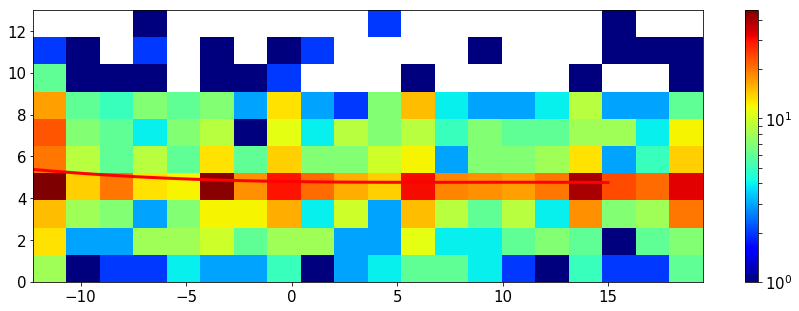

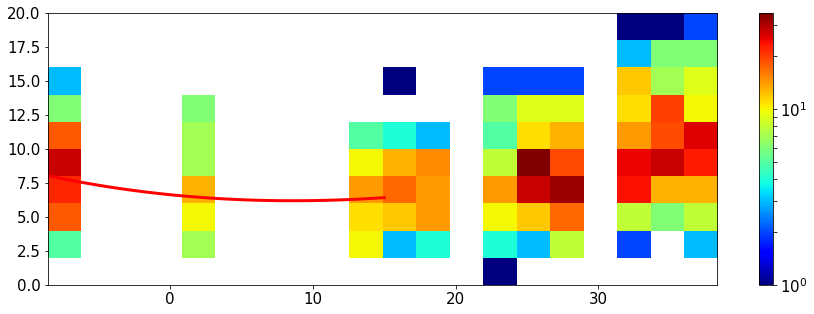

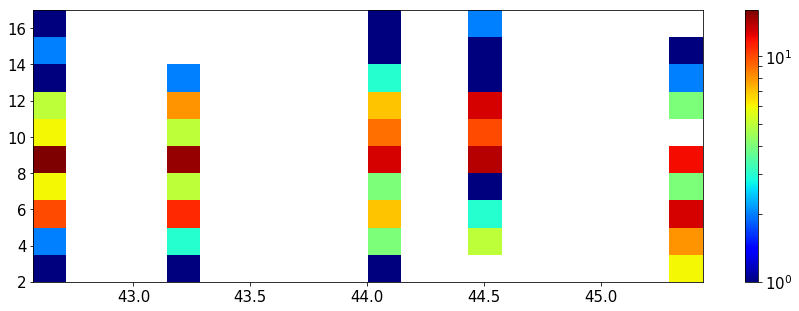

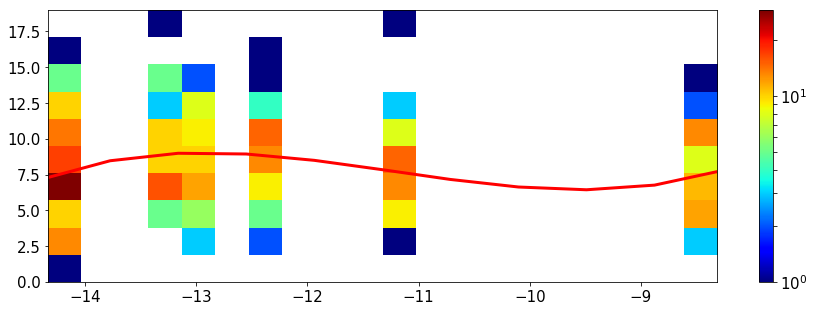

In [91]:
import scipy as sp

for f in glob.iglob("./output/*.csv"): # generator, search immediate subdirectories 
    plt.figure(figsize=(15,5))
    plt.tight_layout()
    df = pd.read_csv(f)
    df.dropna(inplace=True)
    df['lat'] = pd.to_numeric(df['lat'])
    df['lon'] = pd.to_numeric(df['lon'])
    df['altitude'] = pd.to_numeric(df['altitude'])
    df6 = df.loc[df['altitude'] > 12100]

    df6['flux'] = df6.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1)
    plt.hist2d(df6['lat'], df6['flux'], bins=(20,10), norm=matplotlib.colors.LogNorm(), cmap=plt.cm.jet)
    plt.colorbar()
    pf_coef = np.polyfit(df6['lat'],df6['flux'],3)     # polynomial aproximation
    p = np.poly1d(pf_coef)
    plt.plot(sp.linspace(-15,15), p(sp.linspace(-15,15)), 'r-', c='red', lw=3)


In [13]:
dfo.to_csv('./output/ble.csv')